In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [2]:
movies = pd.read_csv("C:/Users/chuen/Music/deep learning/20m/movie.csv")
ratings = pd.read_csv("C:/Users/chuen/Music/deep learning/20m/rating.csv")



## EDA

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [7]:
print(movies.isnull().sum())


movieId    0
title      0
genres     0
dtype: int64


In [8]:
print(ratings.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [9]:
#movies
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|'))
all_genres = movies['genres_list'].explode()

print(all_genres.value_counts())

genres_list
Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
Name: count, dtype: int64


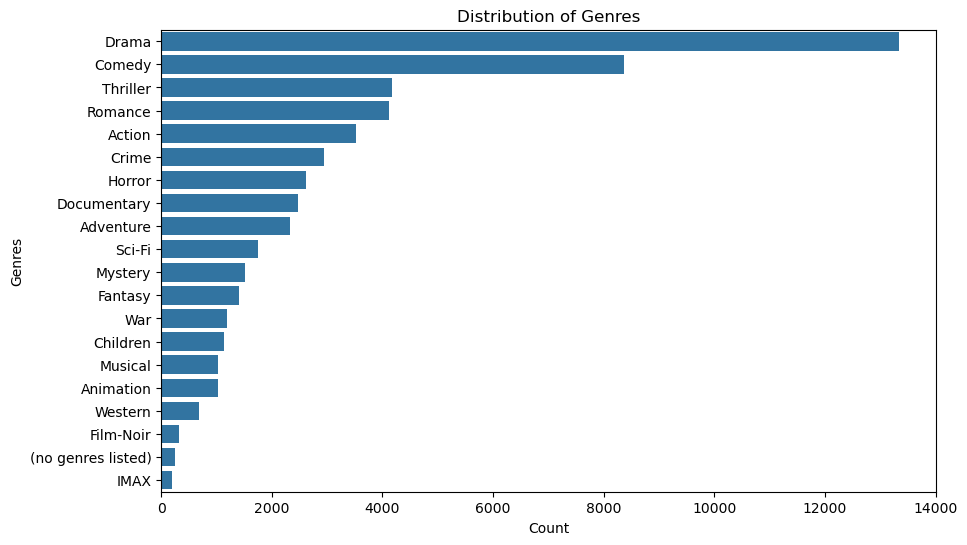

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

In [11]:
#rating

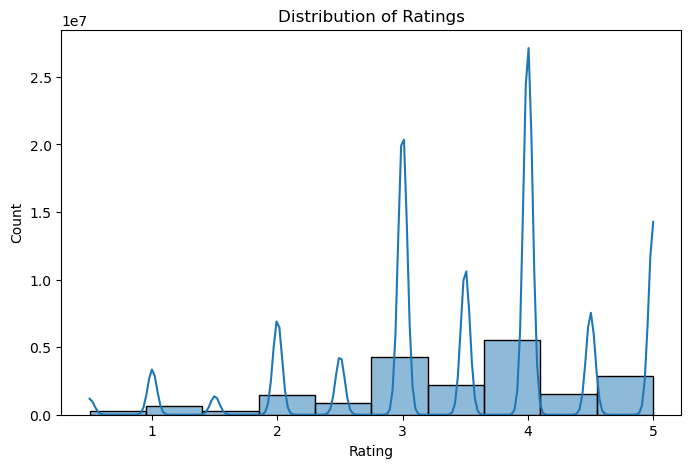

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [13]:

#ตรวจสอบภาพยนตร์ที่มีการให้คะแนนมากที่สุด
rating_count_per_movie = ratings.groupby('movieId')['rating'].count().reset_index()
rating_count_per_movie.columns = ['movieId', 'count']

In [14]:
movie_rating_counts = pd.merge(movies, rating_count_per_movie, on='movieId')

In [15]:
top_rated_movies = movie_rating_counts.sort_values('count', ascending=False).head(10)

In [16]:
print("\nTop 10 Most Rated Movies:")
print(top_rated_movies[['movieId', 'title', 'count']])


Top 10 Most Rated Movies:
      movieId                                      title  count
293       296                        Pulp Fiction (1994)  67310
352       356                        Forrest Gump (1994)  66172
315       318           Shawshank Redemption, The (1994)  63366
587       593           Silence of the Lambs, The (1991)  63299
476       480                       Jurassic Park (1993)  59715
257       260  Star Wars: Episode IV - A New Hope (1977)  54502
108       110                          Braveheart (1995)  53769
583       589          Terminator 2: Judgment Day (1991)  52244
2486     2571                         Matrix, The (1999)  51334
523       527                    Schindler's List (1993)  50054


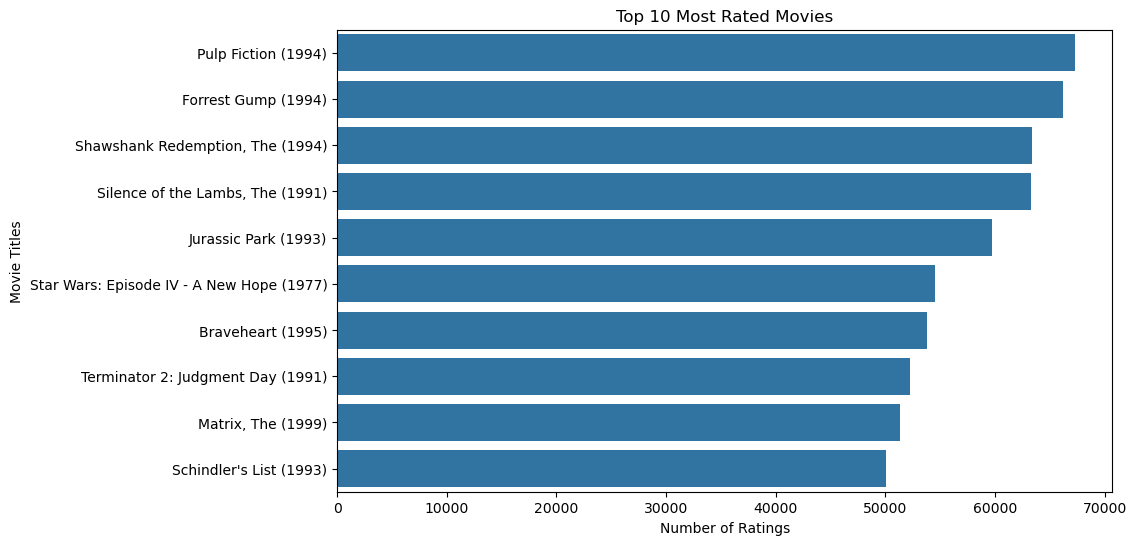

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='title', data=top_rated_movies)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Titles")
plt.show()

## Preprocessing

In [18]:
movies['genres'] = movies['genres'].str.split('|')

In [19]:
# สร้าง binary features สำหรับ genres
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies['genres'])

In [20]:
genre_features

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [21]:
# รวมข้อมูล
movie_features = pd.DataFrame(genre_features, columns=mlb.classes_)
movie_features['movieId'] = movies['movieId']

In [22]:
movie_features

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,4
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,131254
27274,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,131256
27275,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,131258
27276,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,131260


## Model

In [23]:

model = models.Sequential()
model.add(layers.Input(shape=(movie_features.shape[1]-1,))) 
                                                       
model.add(layers.Dense(256, activation='relu'))  
model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(128, activation='relu'))  
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(64, activation='relu'))  
model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(32, activation='relu'))  
model.add(layers.Dense(len(mlb.classes_), activation='sigmoid')) 

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# แยก features และ labels
X = movie_features.drop('movieId', axis=1).values
y = genre_features  # ใช้ genre_features เป็น label

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5040 - loss: 0.2271 - val_accuracy: 0.7093 - val_loss: 0.0110
Epoch 2/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6681 - loss: 0.0239 - val_accuracy: 0.5759 - val_loss: 0.0045
Epoch 3/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6604 - loss: 0.0151 - val_accuracy: 0.7053 - val_loss: 0.0029
Epoch 4/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6720 - loss: 0.0126 - val_accuracy: 0.6441 - val_loss: 0.0020
Epoch 5/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6596 - loss: 0.0109 - val_accuracy: 0.5704 - val_loss: 0.0017
Epoch 6/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6659 - loss: 0.0093 - val_accuracy: 0.5795 - val_loss: 0.0011
Epoch 7/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6398 - loss: 0.0082 - val_accuracy: 0.6199 - val_loss: 0.0010
Epoch 8/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6536 - loss: 0.0084 - val_accuracy: 0.

## Evaluate

In [27]:
from sklearn.metrics import classification_report

In [28]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int) #มากกว่า 0.5 (ซึ่งหมายถึงว่ามีแนวโน้มที่จะเป็นคลาสที่สนใจ) และ False หากน้อยกว่า 0.5


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [29]:
report = classification_report(y_test, y_pred_binary, target_names=mlb.classes_)
print(report)

                    precision    recall  f1-score   support

(no genres listed)       1.00      1.00      1.00        26
            Action       1.00      1.00      1.00       326
         Adventure       1.00      1.00      1.00       250
         Animation       1.00      1.00      1.00       101
          Children       1.00      0.98      0.99       109
            Comedy       1.00      1.00      1.00       777
             Crime       1.00      1.00      1.00       276
       Documentary       1.00      1.00      1.00       274
             Drama       1.00      1.00      1.00      1335
           Fantasy       1.00      1.00      1.00       134
         Film-Noir       1.00      1.00      1.00        32
            Horror       1.00      1.00      1.00       271
              IMAX       1.00      1.00      1.00        11
           Musical       1.00      1.00      1.00        92
           Mystery       1.00      1.00      1.00       165
           Romance       1.00      1.00

## Test

In [30]:
def recommend_movies(movie_id, model, movies, top_n=5):
   
    movie_idx = movies[movies['movieId'] == movie_id].index[0]

   
    pred_genres = model.predict(movie_features.drop('movieId', axis=1).values[movie_idx].reshape(1, -1))

    pred_genres_df = pd.DataFrame(pred_genres, columns=mlb.classes_)
    recommended_indices = np.argsort(pred_genres_df.values[0])[::-1][:top_n] 
                                                           

    # สร้าง DataFrame สำหรับภาพยนตร์ที่แนะนำ
    recommended_movies = movies.iloc[recommended_indices].copy()

    recommended_movies['probability'] = pred_genres_df.values[0][recommended_indices]

    return recommended_movies

In [31]:
recommended_movies = recommend_movies(movie_id=1, model=model, movies=movies )
recommended_movies[['movieId','title', 'genres','probability']]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,movieId,title,genres,probability
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0.999948
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0.999498
5,6,Heat (1995),"[Action, Crime, Thriller]",0.999335
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]",0.999010
4,5,Father of the Bride Part II (1995),[Comedy],0.998463


In [32]:
movies.loc[movies['movieId'] == 1]

,movieId,title,genres,genres_list
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Children, Comedy, Fantasy]"
